# Course Project 
*Option 1*
Daren Yao & Jinsong Yuan

## TASK I


In [121]:
# Uncomment the following lines if you are using Windows!

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

spark = SparkSession.builder \
    .master("yarn") \
    .appName("SparkML-yarn") \
    .getOrCreate()

In [122]:
from pyspark.sql.functions import col, when, isnull, count, lit, avg, sum, isnan, desc, row_number, expr, regexp_extract, concat
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType

#### A. Reading the data

In [123]:
df_list=[]
for i in range(15,23,1):
    df_list.append(spark.read.csv("gs://dataproc-staging-us-central1-178528904223-jzy7r04v/notebooks/jupyter/data/players_{}.csv".format(i),header=True, inferSchema= True))

In [124]:
df_list_female=[]
for i in range(16,23,1):
    df_list_female.append(spark.read.csv("gs://dataproc-staging-us-central1-178528904223-jzy7r04v/notebooks/jupyter/data/female_players_{}.csv".format(i),header=True, inferSchema= True))

#### B. Add new column

In [125]:
for i in range(15,23,1):
    df_list[i-15]=df_list[i-15].withColumn('year',lit(2000+i))
    df_list[i-15]=df_list[i-15].withColumn('gender',lit(1))

In [126]:
for i in range(16,23,1):
    df_list_female[i-16]=df_list_female[i-16].withColumn('year',lit(2000+i))
    df_list_female[i-16]=df_list_female[i-16].withColumn('gender',lit(0))

#### C. Merge the data

In [127]:
# union function needs to be used when two df have the same structure
def union_df(df_list,df_list_female):
    df_union=df_list[0]
    for i in range(15,22,1):
        df_union=df_union.union(df_list[i-14])
    for i in range(16,23,1):
        df_union=df_union.union(df_list_female[i-16])
    return df_union

In [128]:
df_union=union_df(df_list,df_list_female)

In [129]:
# Create a unique identifier unique_id, combining sofifa_id and year
df_union = df_union.withColumn('unique_id', concat(col('sofifa_id'), lit('_'), col('year')))

# checking the result
df_union.select('sofifa_id', 'year', 'unique_id').show(5)


+---------+----+-----------+
|sofifa_id|year|  unique_id|
+---------+----+-----------+
|   158023|2015|158023_2015|
|    20801|2015| 20801_2015|
|     9014|2015|  9014_2015|
|    41236|2015| 41236_2015|
|   167495|2015|167495_2015|
+---------+----+-----------+
only showing top 5 rows



#### D. Data Cleaning

##### D.1 _Dropping columns with high nullValue ratio_

In [130]:
df_uncleaned=df_union

In [131]:
missing_values = ['NA', 'NULL', 'NAN', 'NaN', 'na', 'null', 'nan', '']
def replace_missing_values(df, missing_values):
    for c in df.columns:
        df = df.withColumn(c, when(col(c).isin(missing_values), None).otherwise(col(c)))
    return df
# Transferring all the nullValues into None
df_null_transferred = replace_missing_values(df_uncleaned, missing_values)

In [132]:
# Function to calculate the null ratio

def show_null_ratio(df):
    total_count = df.count()
    columns = df.columns
    null_count_expr = [
        count(when(col(c).isNull() , c)).alias(f'{c}_null_count') for c in columns
    ]
    
    null_counts_df = df.agg(*null_count_expr)
    
    # Calculate the percentage of null values in each column
    for c in columns:
        null_counts_df = null_counts_df.withColumn(c, col(f'{c}_null_count') / total_count)
        null_counts_df=null_counts_df.drop(f'{c}_null_count')
    
    null_counts_df.show(vertical=True)
    # return the null_ratio df for further use
    return null_counts_df

In [133]:
# A table showing the null ratio of each columns vertically
null_ratio_df=show_null_ratio(df_null_transferred)

24/11/15 01:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1216.4 KiB
24/11/15 01:17:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


-RECORD 0-------------------------------------------
 sofifa_id                   | 0.0                  
 player_url                  | 0.0                  
 short_name                  | 0.0                  
 long_name                   | 0.0                  
 player_positions            | 0.0                  
 overall                     | 0.0                  
 potential                   | 0.0                  
 value_eur                   | 0.028373855864969547 
 wage_eur                    | 0.026468407668909323 
 age                         | 0.0                  
 dob                         | 0.0                  
 height_cm                   | 0.0                  
 weight_kg                   | 0.0                  
 club_team_id                | 0.02684256840559024  
 club_name                   | 0.02684256840559024  
 league_name                 | 0.02684256840559024  
 league_level                | 0.029510195880074554 
 club_position               | 0.0268425684055

In [134]:
#getting a list of ratios
ratio_row = null_ratio_df.collect()[0]
col_toomuchnull = [null_ratio_df.columns[i] for i in range(len(ratio_row)) if ratio_row[i] > 0.5]
print(col_toomuchnull)
# now we know the columns with nullValue ratio over 50%.

24/11/15 01:17:44 WARN DAGScheduler: Broadcasting large task binary with size 1216.4 KiB
24/11/15 01:18:00 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


['club_loaned_from', 'nation_team_id', 'nation_position', 'nation_jersey_number', 'player_tags', 'player_traits', 'goalkeeping_speed', 'nation_logo_url']


In [135]:
# dropping the columns with high nullValue ratio
df_afterdrop=df_null_transferred
for c in col_toomuchnull:
    df_afterdrop=df_afterdrop.drop(c)

Besides, all of the url colums are useless

In [136]:
columns_to_drop = [col_name for col_name in df_afterdrop.columns if 'url' in col_name]

# drop the columns that contain url
df_afterdrop = df_afterdrop.drop(*columns_to_drop)

##### D.2 _Checking the dtypes_

In [137]:
# Getting a list of the rest null cols
col_ratio = show_null_ratio(df_afterdrop).collect()[0]

24/11/15 01:18:45 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


-RECORD 0-------------------------------------------
 sofifa_id                   | 0.0                  
 short_name                  | 0.0                  
 long_name                   | 0.0                  
 player_positions            | 0.0                  
 overall                     | 0.0                  
 potential                   | 0.0                  
 value_eur                   | 0.028373855864969547 
 wage_eur                    | 0.026468407668909323 
 age                         | 0.0                  
 dob                         | 0.0                  
 height_cm                   | 0.0                  
 weight_kg                   | 0.0                  
 club_team_id                | 0.02684256840559024  
 club_name                   | 0.02684256840559024  
 league_name                 | 0.02684256840559024  
 league_level                | 0.029510195880074554 
 club_position               | 0.02684256840559024  
 club_jersey_number          | 0.0268425684055

24/11/15 01:19:01 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


In [138]:
col_have_null = [df_afterdrop.columns[i] for i in range(len(col_ratio)) if col_ratio[i] > 0]
print(col_have_null)
# now we know the columns that have null value.

['value_eur', 'wage_eur', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_joined', 'club_contract_valid_until', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'mentality_composure']


In [139]:
df_afterdrop.select(col_have_null).show(3)

24/11/15 01:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1005.5 KiB


+---------+--------+------------+-----------------+--------------------+------------+-------------+------------------+-----------+-------------------------+------------------+----+--------+-------+---------+---------+------+-------------------+
|value_eur|wage_eur|club_team_id|        club_name|         league_name|league_level|club_position|club_jersey_number|club_joined|club_contract_valid_until|release_clause_eur|pace|shooting|passing|dribbling|defending|physic|mentality_composure|
+---------+--------+------------+-----------------+--------------------+------------+-------------+------------------+-----------+-------------------------+------------------+----+--------+-------+---------+---------+------+-------------------+
|  1.005E8|550000.0|       241.0|     FC Barcelona|Spain Primera Div...|           1|           CF|                10| 2004-07-01|                     2018|              NULL|  93|      89|     86|       96|       27|    63|               NULL|
|    7.9E7|375000.0|

In [140]:
# checking the true dtype (because there's a lot of NULL in this column, I'm not sure if it's a int)
df_afterdrop.groupby('mentality_composure').count().orderBy(col('count').desc()).show(truncate=False)

+-------------------+-----+
|mentality_composure|count|
+-------------------+-----+
|NULL               |32026|
|60                 |4248 |
|65                 |4160 |
|58                 |4038 |
|55                 |3996 |
|62                 |3966 |
|64                 |3705 |
|59                 |3642 |
|63                 |3498 |
|68                 |3381 |
|66                 |3348 |
|57                 |3323 |
|56                 |3255 |
|67                 |3237 |
|61                 |3165 |
|70                 |3017 |
|52                 |2878 |
|54                 |2756 |
|50                 |2749 |
|69                 |2648 |
+-------------------+-----+
only showing top 20 rows



In [141]:
df_afterdrop.select(col_have_null).dtypes

[('value_eur', 'string'),
 ('wage_eur', 'string'),
 ('club_team_id', 'string'),
 ('club_name', 'string'),
 ('league_name', 'string'),
 ('league_level', 'string'),
 ('club_position', 'string'),
 ('club_jersey_number', 'string'),
 ('club_joined', 'string'),
 ('club_contract_valid_until', 'string'),
 ('release_clause_eur', 'string'),
 ('pace', 'int'),
 ('shooting', 'int'),
 ('passing', 'int'),
 ('dribbling', 'int'),
 ('defending', 'int'),
 ('physic', 'int'),
 ('mentality_composure', 'string')]

_Some of the columns that have null value has a wrong dtype_

In [142]:
col_int=['value_eur','wage_eur','club_team_id','league_level','club_jersey_number','club_contract_valid_until','release_clause_eur','pace','shooting','passing','dribbling','defending','physic','mentality_composure']

In [143]:
# Transferring the data type
def cast_columns(df, columns_to_cast):
    for col_name in columns_to_cast:
        df = df.withColumn(col_name, df[col_name].cast(IntegerType()))
    return df

df_transferType = cast_columns(df_afterdrop, col_int)

Except the columns that has nullValue, some other columns are inferred incorrectly

There are several potential problems with the datatype. Further work could be done when optimizing different ML models. Among them, the position rating (i.e. ls          |st          |rs          |lw .....) should be IntegerType() to represent the players capability of different roles.

In [144]:
# dob is a DataType(), maybe could also be changed into Timestamp? 
# club_joined could be changed to timestamp (now it's StringType)
# body_type is like Normal (170-) ,Normal (170-185). Maybe it could also be changed to integers?

In [145]:
# The Position Ratings has a format of n+3, which means the boost a player can gain in the FIFA game. 
# For example, player performance can be influenced by team chemistry and player morale, leading to temporary boosts.
# However, it got inferred as StringType(), which isn't helpful for ML modeling.
# Therefore, I transferred it into IntegerType():
position_columns = [
    'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw',
    'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm',
    'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
    'lcb', 'cb', 'rcb', 'rb', 'gk'
]
# Pyspark has a built-in funcion for this : imported before (regexp_extract)

# Split the string and calculate the sum (by overwriting the original columns)
# colums have scenarios that players position ratings are N+m, N-m or N
# Pattern to extract the base number (N)
pattern_base = r'^(\d+)'

# Pattern to extract the modifier with its sign (+M or -M)
pattern_modifier = r'([+-]\d+)$'

df_position_calculated=df_transferType
for col_name in position_columns:
    # Extract the base rating
    base = regexp_extract(col(col_name), pattern_base, 1).cast(IntegerType())
    
    # Extract the modifier (if any), including the sign
    modifier = regexp_extract(col(col_name), pattern_modifier, 1).cast(IntegerType())
    
    # Compute the effective rating
    df_position_calculated = df_position_calculated.withColumn(
        col_name,
        base + when(modifier.isNotNull(), modifier).otherwise(0)
    )

# I used GPT for constructing the code. Also, GPT inspired me to use regexp_extract[2].
# [2]OpenAI. (2024). *ChatGPT* [Large language model]. https://chat.openai.com/

In [146]:
df_position_calculated.select(position_columns).show()
df_transferType.select(position_columns).show()

24/11/15 01:19:57 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| ls| st| rs| lw| lf| cf| rf| rw|lam|cam|ram| lm|lcm| cm|rcm| rm|lwb|ldm|cdm|rdm|rwb| lb|lcb| cb|rcb| rb| gk|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 92| 92| 92| 95| 93| 93| 93| 95| 95| 95| 95| 93| 82| 82| 82| 93| 65| 65| 65| 65| 65| 57| 48| 48| 48| 57| 18|
| 92| 92| 92| 92| 92| 92| 92| 92| 92| 92| 92| 90| 80| 80| 80| 90| 66| 66| 66| 66| 66| 60| 55| 55| 55| 60| 19|
| 87| 87| 87| 90| 90| 90| 90| 90| 90| 90| 90| 90| 81| 81| 81| 90| 67| 67| 67| 67| 67| 58| 49| 49| 49| 58| 17|
| 90| 90| 90| 87| 89| 89| 89| 87| 89| 89| 89| 86| 79| 79| 79| 86| 64| 68| 68| 68| 64| 59| 58| 58| 58| 59| 20|
| 41| 41| 41| 39| 40| 40| 40| 39| 39| 39| 39| 41| 39| 39| 39| 41| 39| 43| 43| 43| 39| 39| 41| 41| 41| 39| 90|
| 80| 80| 80| 89| 85| 85| 85| 89| 89| 89| 89| 89| 89| 89| 89| 89| 79| 80| 80| 80| 79| 73| 66| 66| 66| 73| 17|
| 89| 89| 

24/11/15 01:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1399.7 KiB


+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  ls|  st|  rs|  lw|  lf|  cf|  rf|  rw| lam| cam| ram|  lm| lcm|  cm| rcm|  rm| lwb| ldm| cdm| rdm| rwb|  lb| lcb|  cb| rcb|  rb|  gk|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|89+3|89+3|89+3|92+3|90+3|90+3|90+3|92+3|92+3|92+3|92+3|90+3|79+3|79+3|79+3|90+3|62+3|62+3|62+3|62+3|62+3|54+3|45+3|45+3|45+3|54+3|15+3|
|91+1|91+1|91+1|89+3|91+1|91+1|91+1|89+3|89+3|89+3|89+3|87+3|77+3|77+3|77+3|87+3|63+3|63+3|63+3|63+3|63+3|57+3|52+3|52+3|52+3|57+3|16+3|
|84+3|84+3|84+3|88+2|87+3|87+3|87+3|88+2|88+2|88+2|88+2|87+3|78+3|78+3|78+3|87+3|64+3|64+3|64+3|64+3|64+3|55+3|46+3|46+3|46+3|55+3|14+3|
|87+3|87+3|87+3|84+3|86+3|86+3|86+3|84+3|86+3|86+3|86+3|83+3|76+3|76+3|76+3|83+3|61+3|65+3|65+3|65+3|61+3|56+3|55+3|55+3|55+3|56+3|17+3|
|38+3|38+3|38+3|36+3|37+3|37+3|37+3|36+3|

##### D.3 _Null Value Handling_

D.3.a _Female players_

All of the female players have a lot of null columns. Therefore, female players' data should be seperately treated since treating the whole data with imputation may cause some unexpected bias. 


In [147]:
df_female=df_position_calculated.filter(col('gender')==0)
df_male=df_position_calculated.filter(col('gender')==1)

In [148]:
#getting a list of the rest null cols
col_ratio_female = show_null_ratio(df_female).collect()[0]

24/11/15 01:20:47 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


-RECORD 0------------------------------------------
 sofifa_id                   | 0.0                 
 short_name                  | 0.0                 
 long_name                   | 0.0                 
 player_positions            | 0.0                 
 overall                     | 0.0                 
 potential                   | 0.0                 
 value_eur                   | 0.9808377896613191  
 wage_eur                    | 0.9795008912655971  
 age                         | 0.0                 
 dob                         | 0.0                 
 height_cm                   | 0.0                 
 weight_kg                   | 0.0                 
 club_team_id                | 1.0                 
 club_name                   | 1.0                 
 league_name                 | 1.0                 
 league_level                | 1.0                 
 club_position               | 1.0                 
 club_jersey_number          | 1.0                 
 club_joined

24/11/15 01:20:54 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


In [149]:
# showing the lists that female players has a very high ratio of nullValue
col_have_null = [df_female.columns[i] for i in range(len(col_ratio_female)) if col_ratio_female[i]>0.9]
print(col_have_null)

['value_eur', 'wage_eur', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_joined', 'club_contract_valid_until', 'release_clause_eur']


In [150]:
col_female_high_null=['value_eur', 'wage_eur', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_joined', 'club_contract_valid_until', 'release_clause_eur']

In [151]:
df_female.select(col_female_high_null).printSchema()

root
 |-- value_eur: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- club_team_id: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- release_clause_eur: integer (nullable = true)



In [152]:
# filling all the null string columns with Unknown
df_female = df_female.fillna({'club_name': 'Unknown','league_name': 'Unknown','club_position': 'Unknown','club_joined': 'Unknown'})

- Although it may cause bias without seperately treating null columns, for most of the integer columns in the female df, there isn't much other data for correspondence.
- So we still have to put them back together

In [153]:
df_all_gender=df_male.union(df_female)

D.3.b All players

In [154]:
schema = df_all_gender.schema

# obtaining the string cols
string_columns = [field.name for field in schema.fields if isinstance(field.dataType, StringType)]

# obtaining the numeric cols
numeric_columns = [field.name for field in schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]


In [155]:
# Finding cols with nullValues in StringTypes
string_columns_with_null = []
for col_name in string_columns:
    null_count = df_all_gender.filter(isnull(col(col_name))).count()
    if null_count > 0:
        string_columns_with_null.append(col_name)


In [156]:
for col_name in string_columns_with_null:
    # It seems that there isn't a built-in function to compute mode
    mode_df = df_all_gender.groupBy(col_name).agg(count(col_name).alias('count')).orderBy(desc('count'))
    mode = mode_df.first()[0]
    
    # fill it
    df_all_gender = df_all_gender.fillna({col_name: mode})

In [157]:
df_string_filled=df_all_gender

In [158]:
# Finding cols with nullValues in numeric columns
numeric_columns_with_null = []
for col_name in numeric_columns:
    null_count = df_all_gender.filter(isnull(col(col_name))).count()
    if null_count > 0:
        numeric_columns_with_null.append(col_name)

In [159]:
# obtain median for integers
for col_name in numeric_columns_with_null:
    median = df_string_filled.approxQuantile(col_name, [0.5], 0.001)[0]
    df_string_filled = df_string_filled.fillna({col_name: median})

In [160]:
df_filled=df_string_filled

In [161]:
df_cleaned=df_filled

## TASK II

#### A. Contract Finish

In [60]:
df_read = df_cleaned
df_read=df_read.filter(col('gender')==1)
df_read.show(1, vertical=True)

24/11/12 19:46:59 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 50, Column 14: Compiling "project_doConsume_0(int project_expr_0_0, boolean project_exprIsNull_0_0, UTF8String project_expr_1_0, boolean project_exprIsNull_1_0, UTF8String project_expr_2_0, boolean project_exprIsNull_2_0, UTF8String project_expr_3_0, boolean project_exprIsNull_3_0, int project_expr_4_0, boolean project_exprIsNull_4_0, int project_expr_5_0, boolean project_exprIsNull_5_0, UTF8String project_expr_6_0, boolean project_exprIsNull_6_0, UTF8String project_expr_7_0, boolean project_exprIsNull_7_0, int project_expr_8_0, boolean project_exprIsNull_8_0, int project_expr_9_0, boolean project_exprIsNull_9_0, int project_expr_10_0, boolean project_exprIsNull_10_0, int project_expr_11_0, boolean project_exprIsNull_11_0, UTF8String project_expr_12_0, boolean project_exprIsN

24/11/12 19:46:59 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 50, Column 14: Compiling "project_doConsume_0(int project_expr_0_0, boolean project_exprIsNull_0_0, UTF8String project_expr_1_0, boolean project_exprIsNull_1_0, UTF8String project_expr_2_0, boolean project_exprIsNull_2_0, UTF8String project_expr_3_0, boolean project_exprIsNull_3_0, int project_expr_4_0, boolean project_exprIsNull_4_0, int project_expr_5_0, boolean project_exprIsNull_5_0, UTF8String project_expr_6_0, boolean project_exprIsNull_6_0, UTF8String project_expr_7_0, boolean project_exprIsNull_7_0, int project_expr_8_0, boolean project_exprIsNull_8_0, int project_expr_9_0, boolean project_exprIsNull_9_0, int project_expr_10_0, boolean project_exprIsNull_10_0, int project_expr_11_0, boolean project_exprIsNull_11_0, UTF8String project_expr_12_0, boolean project_exprIsN

24/11/12 19:47:00 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 50, Column 14: Compiling "project_doConsume_0(int project_expr_0_0, boolean project_exprIsNull_0_0, UTF8String project_expr_1_0, boolean project_exprIsNull_1_0, UTF8String project_expr_2_0, boolean project_exprIsNull_2_0, UTF8String project_expr_3_0, boolean project_exprIsNull_3_0, int project_expr_4_0, boolean project_exprIsNull_4_0, int project_expr_5_0, boolean project_exprIsNull_5_0, UTF8String project_expr_6_0, boolean project_exprIsNull_6_0, UTF8String project_expr_7_0, boolean project_exprIsNull_7_0, int project_expr_8_0, boolean project_exprIsNull_8_0, int project_expr_9_0, boolean project_exprIsNull_9_0, int project_expr_10_0, boolean project_exprIsNull_10_0, int project_expr_11_0, boolean project_exprIsNull_11_0, UTF8String project_expr_12_0, boolean project_exprIsN

24/11/12 19:47:01 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 50, Column 14: Compiling "project_doConsume_0(int project_expr_0_0, boolean project_exprIsNull_0_0, UTF8String project_expr_1_0, boolean project_exprIsNull_1_0, UTF8String project_expr_2_0, boolean project_exprIsNull_2_0, UTF8String project_expr_3_0, boolean project_exprIsNull_3_0, int project_expr_4_0, boolean project_exprIsNull_4_0, int project_expr_5_0, boolean project_exprIsNull_5_0, UTF8String project_expr_6_0, boolean project_exprIsNull_6_0, UTF8String project_expr_7_0, boolean project_exprIsNull_7_0, int project_expr_8_0, boolean project_exprIsNull_8_0, int project_expr_9_0, boolean project_exprIsNull_9_0, int project_expr_10_0, boolean project_exprIsNull_10_0, int project_expr_11_0, boolean project_exprIsNull_11_0, UTF8String project_expr_12_0, boolean project_exprIsN

24/11/12 19:47:02 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 50, Column 14: Compiling "project_doConsume_0(int project_expr_0_0, boolean project_exprIsNull_0_0, UTF8String project_expr_1_0, boolean project_exprIsNull_1_0, UTF8String project_expr_2_0, boolean project_exprIsNull_2_0, UTF8String project_expr_3_0, boolean project_exprIsNull_3_0, int project_expr_4_0, boolean project_exprIsNull_4_0, int project_expr_5_0, boolean project_exprIsNull_5_0, UTF8String project_expr_6_0, boolean project_exprIsNull_6_0, UTF8String project_expr_7_0, boolean project_exprIsNull_7_0, int project_expr_8_0, boolean project_exprIsNull_8_0, int project_expr_9_0, boolean project_exprIsNull_9_0, int project_expr_10_0, boolean project_exprIsNull_10_0, int project_expr_11_0, boolean project_exprIsNull_11_0, UTF8String project_expr_12_0, boolean project_exprIsN

24/11/12 19:47:02 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 50, Column 14: Compiling "project_doConsume_0(int project_expr_0_0, boolean project_exprIsNull_0_0, UTF8String project_expr_1_0, boolean project_exprIsNull_1_0, UTF8String project_expr_2_0, boolean project_exprIsNull_2_0, UTF8String project_expr_3_0, boolean project_exprIsNull_3_0, int project_expr_4_0, boolean project_exprIsNull_4_0, int project_expr_5_0, boolean project_exprIsNull_5_0, UTF8String project_expr_6_0, boolean project_exprIsNull_6_0, UTF8String project_expr_7_0, boolean project_exprIsNull_7_0, int project_expr_8_0, boolean project_exprIsNull_8_0, int project_expr_9_0, boolean project_exprIsNull_9_0, int project_expr_10_0, boolean project_exprIsNull_10_0, int project_expr_11_0, boolean project_exprIsNull_11_0, UTF8String project_expr_12_0, boolean project_exprIsN

24/11/12 19:47:03 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 50, Column 14: Compiling "project_doConsume_0(int project_expr_0_0, boolean project_exprIsNull_0_0, UTF8String project_expr_1_0, boolean project_exprIsNull_1_0, UTF8String project_expr_2_0, boolean project_exprIsNull_2_0, UTF8String project_expr_3_0, boolean project_exprIsNull_3_0, int project_expr_4_0, boolean project_exprIsNull_4_0, int project_expr_5_0, boolean project_exprIsNull_5_0, UTF8String project_expr_6_0, boolean project_exprIsNull_6_0, UTF8String project_expr_7_0, boolean project_exprIsNull_7_0, int project_expr_8_0, boolean project_exprIsNull_8_0, int project_expr_9_0, boolean project_exprIsNull_9_0, int project_expr_10_0, boolean project_exprIsNull_10_0, int project_expr_11_0, boolean project_exprIsNull_11_0, UTF8String project_expr_12_0, boolean project_exprIsN

24/11/12 19:47:04 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 50, Column 14: Compiling "project_doConsume_0(int project_expr_0_0, boolean project_exprIsNull_0_0, UTF8String project_expr_1_0, boolean project_exprIsNull_1_0, UTF8String project_expr_2_0, boolean project_exprIsNull_2_0, UTF8String project_expr_3_0, boolean project_exprIsNull_3_0, int project_expr_4_0, boolean project_exprIsNull_4_0, int project_expr_5_0, boolean project_exprIsNull_5_0, UTF8String project_expr_6_0, boolean project_exprIsNull_6_0, UTF8String project_expr_7_0, boolean project_exprIsNull_7_0, int project_expr_8_0, boolean project_exprIsNull_8_0, int project_expr_9_0, boolean project_exprIsNull_9_0, int project_expr_10_0, boolean project_exprIsNull_10_0, int project_expr_11_0, boolean project_exprIsNull_11_0, UTF8String project_expr_12_0, boolean project_exprIsN

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 650000               
 wage_eur                    | 550000               
 age                         | 27                   
 dob                         | 1987-06-24           
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241                  
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF                   
 club_jersey_number          | 10             

In [61]:
'''x = 2015  
y = 5   
z = 2018'''

'x = 2015  \ny = 5   \nz = 2018'

In [62]:
from pyspark.sql import functions as F

def get_top_clubs_by_year(df, x, y, z):
    df_filter = df.filter((df['year'] == x) & (df['club_contract_valid_until'] >= z))
    df_agg = df_filter.groupBy('club_name').agg(F.count('sofifa_id').alias('player_count'))
    df_club_order = df_agg.orderBy(F.desc('player_count')).limit(y)
    
    return df_club_order.select('club_name')

In [63]:
x = 2015
y = 5
z = 2018
top_clubs = get_top_clubs_by_year(df_read, x, y, z)
top_clubs.show()

+----------------+
|       club_name|
+----------------+
|         Unknown|
|  Fortaleza CEIF|
| Boyacá Chicó FC|
|      La Equidad|
|Monarcas Morelia|
+----------------+



In [64]:
'''from pyspark.sql import functions as F
df_filter=df_read.filter((df_read['year']==x)&(df_read['club_contract_valid_until']>=z))
df_agg=df_filter.groupBy('club_name').agg(F.count('sofifa_id').alias('player_count'))
df_club_order=df_agg.orderBy(F.desc('player_count')).limit(y)
df_club_order.select('club_name').show()
'''
                                          

"from pyspark.sql import functions as F\ndf_filter=df_read.filter((df_read['year']==x)&(df_read['club_contract_valid_until']>=z))\ndf_agg=df_filter.groupBy('club_name').agg(F.count('sofifa_id').alias('player_count'))\ndf_club_order=df_agg.orderBy(F.desc('player_count')).limit(y)\ndf_club_order.select('club_name').show()\n"

#### B top players count

In [65]:
from pyspark.sql import Window
df_agg=df_read.groupBy('year','nationality_name').agg(F.count('sofifa_id').alias('players_count'))
windows=Window.partitionBy('year')
windows_desc=windows.orderBy(F.desc('players_count'))
df_year_nation_rank=df_agg.withColumn('rank',F.row_number().over(windows_desc))
df_rank1=df_year_nation_rank.filter(F.col('rank')==1).select('year', 'nationality_name', 'players_count').show()

+----+----------------+-------------+
|year|nationality_name|players_count|
+----+----------------+-------------+
|2015|         England|         1627|
|2016|         England|         1519|
|2017|         England|         1627|
|2018|         England|         1633|
|2019|         England|         1625|
|2020|         England|         1670|
|2021|         England|         1685|
|2022|         England|         1719|
+----+----------------+-------------+



#### C Extreme Average Age

In [66]:
import sys
from pyspark.sql.functions import avg, desc, asc, col

def get_clubs_by_avg_age(df, x, y, sequence='desc'):
    if x <= 0:
        print('Error: Limit x must be greater than 0')
        sys.exit()
    df_year = df.filter(df['year'] == y)
    df_club = df_year.groupBy('club_name')
    df_avg = df_club.agg(avg('age').alias('avg_age'))
    if sequence == 'desc':
        df_seq = df_avg.orderBy(desc('avg_age'))
    elif sequence == 'asc':
        df_seq = df_avg.orderBy(asc('avg_age'))
    else:
        print("Error: Sequence must be 'asc' or 'desc'")
        sys.exit()
    df_rows = df_seq.limit(x).collect()
    if df_rows:
        last_row = df_rows[-1]
        last_avg_age = last_row['avg_age']
    else:
        return df_seq.limit(x)  # Return if no data
    df_same = df_seq.filter(col('avg_age') == last_avg_age).collect()
    df_other = [row for row in df_rows if row['avg_age'] != last_avg_age]
    df_final = df_other + df_same
    
    return df_final


In [67]:
# Example usage
x = 5
y = 2015
sequence = 'desc'
clubs_by_avg_age = get_clubs_by_avg_age(df_read, x, y, sequence)
for row in clubs_by_avg_age:
    print(row)


Row(club_name='Cruz Azul', avg_age=28.071428571428573)
Row(club_name='Arsenal Tula', avg_age=28.04)
Row(club_name='Podbeskidzie Bielsko-Biała', avg_age=27.962962962962962)
Row(club_name='Fenerbahçe SK', avg_age=27.88)
Row(club_name='Leones Negros de la UdeG', avg_age=27.79310344827586)


In [68]:
'''df=df_read'''

'df=df_read'

In [69]:
'''import sys
from pyspark.sql.functions import avg, desc,asc, col
x=5
y=2015
sequence='desc'
if x<=0:
    print('error')
    sys.exit()
df_year=df.filter(df['year']==y)
df_club=df_year.groupBy('club_name')
df_avg=df_club.agg(avg('age').alias('avg_age'))
if sequence=='desc':
    df_seq=df_avg.orderBy(desc('avg_age'))
elif sequence=='asc':
    df_seq=df_avg.orderBy(asc('avg_age'))
'''

"import sys\nfrom pyspark.sql.functions import avg, desc,asc, col\nx=5\ny=2015\nsequence='desc'\nif x<=0:\n    print('error')\n    sys.exit()\ndf_year=df.filter(df['year']==y)\ndf_club=df_year.groupBy('club_name')\ndf_avg=df_club.agg(avg('age').alias('avg_age'))\nif sequence=='desc':\n    df_seq=df_avg.orderBy(desc('avg_age'))\nelif sequence=='asc':\n    df_seq=df_avg.orderBy(asc('avg_age'))\n"

In [70]:
'''df_rows=df_seq.limit(x).collect()
last_row=df_rows[-1]
df_same=df_seq.filter(col('avg_age')==last_row['avg_age']).collect()

df_other=[row for row in df_rows if row['avg_age']!=last_row['avg_age']]
df_final=df_other+df_same
df_final'''

"df_rows=df_seq.limit(x).collect()\nlast_row=df_rows[-1]\ndf_same=df_seq.filter(col('avg_age')==last_row['avg_age']).collect()\n\ndf_other=[row for row in df_rows if row['avg_age']!=last_row['avg_age']]\ndf_final=df_other+df_same\ndf_final"

<center><h1>TASK III</h1></center>

# TASK III PyTorch

In [85]:
from pyspark.sql.functions import col, when, isnull, count, lit, avg, sum, isnan, desc, row_number, expr, regexp_extract, concat
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

In [86]:
df_read=df_cleaned.filter(col('gender')==1) # Because we didn't actually read the data back


### Run these codes:    (1)->(7)

**(1) Contract year calculation**

In [87]:
from pyspark.sql import functions as F
df_read = df_read.withColumn("contract_years_remaining", F.col("club_contract_valid_until") - F.year(F.col("club_joined")))


**(2) furtherly drop unnecessary features**

In [88]:
delete_features = ['gender','nationality_id', 'nationality_name', 'work_rate', 'body_type', 'real_face', 'short_name', 'long_name','sofifa_id','unique_id','year','player_positions', 'dob', 'club_joined','club_name']
df_read = df_read.drop(*delete_features)


**(3) Define Columns Type**

In [89]:
continuous_cols = ['overall','potential','wage_eur','age','height_cm', 'weight_kg', 'league_level','weak_foot', 'skill_moves','international_reputation',
                  'release_clause_eur','pace', "shooting", "passing", "dribbling", "defending", "physic", "attacking_crossing", "attacking_finishing", 
                   "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve",
                   "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed",
                   "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina",
                   "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning",
                   "mentality_vision", "mentality_penalties", "mentality_composure", "defending_marking_awareness", "defending_standing_tackle",
                   "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", 
                   "goalkeeping_reflexes", "ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "cm", "rcm", "rm", 
                   "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk",'contract_years_remaining',
                    'overall','club_team_id', 'club_jersey_number', 'club_contract_valid_until']
nominal_cols = []
binary_cols = ['preferred_foot']


**(4) Transfer binary_cols**

In [90]:
from pyspark.sql.functions import when, col

df_read = df_read.withColumn(
    "preferred_foot", 
    when(col("preferred_foot") == "Left", 0.0)
    .when(col("preferred_foot") == "Right", 1.0)
    .otherwise(None)  
)
df_read.show(1,vertical=True)

24/11/15 00:28:26 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


-RECORD 0-------------------------------------------
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 650000               
 wage_eur                    | 550000               
 age                         | 27                   
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241                  
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF                   
 club_jersey_number          | 10                   
 club_contract_valid_until   | 2018                 
 preferred_foot              | 0.0                  
 weak_foot                   | 3                    
 skill_moves                 | 4                    
 international_reputation    | 5                    
 release_clause_eur          | 1300000        

**(5) The transformer pipeline**

In [91]:

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):                             
        output_df = dataset.withColumn('outcome', col('value_eur')).drop("value_eur")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()
    
    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols ) # actually there's no nominal cols to transfer

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ['overall','club_team_id', 'club_jersey_number', 'club_contract_valid_until']

    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    
    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    


    # Creating the outcome and conduct standardization
    stage_outcome = OutcomeCreater()
    assembler_outcome = VectorAssembler(inputCols=['outcome'], outputCol='assembled_outcome')
    scaler_outcome = StandardScaler(inputCol='assembled_outcome', outputCol='scaled_outcome', withMean=True, withStd=True)
    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler, stage_outcome,assembler_outcome, scaler_outcome,stage_column_dropper])
    return pipeline 

**(6) Fit & Transform**

In [92]:
train_df, test_df, validate_df = df_read.randomSplit([0.8, 0.1, 0.1], seed=42)

# 打印每个数据集的长度（可选）
print(f"训练集长度: {train_df.count()}")
print(f"测试集长度: {test_df.count()}")
print(f"验证集长度: {validate_df.count()}")

24/11/15 00:28:31 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


训练集长度: 113881


24/11/15 00:29:05 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


测试集长度: 14149


24/11/15 00:29:25 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


验证集长度: 14232


In [93]:

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(train_df)
from pyspark.ml.functions import vector_to_array
train_tran = preprocess_pipeline_model.transform(train_df)
test_tran = preprocess_pipeline_model.transform(test_df)
validate_tran = preprocess_pipeline_model.transform(validate_df)
# df_tran = df_tran.drop('outcome')
# #vector_to_array is necessary since the standardization process transfers the outcome to a vector
# df_final = df_tran.withColumn('outcome',vector_to_array(col('scaled_outcome'))[0])
# df = df_final.drop('scaled_outcome','assembled_outcome','league_name','club_position')




24/11/15 00:30:08 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/15 00:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1374.6 KiB
24/11/15 00:30:22 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/11/15 00:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1429.4 KiB
24/11/15 00:30:40 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/15 00:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1390.1 KiB


In [94]:
def process_transformed_df(df_transformed):

    df_tran = df_transformed.drop('outcome')
    df_final = df_tran.withColumn('outcome', vector_to_array(col('scaled_outcome'))[0])
    df_final = df_final.drop('scaled_outcome', 'assembled_outcome', 'league_name', 'club_position')
    
    return df_final

# 处理各个数据集
train_final = process_transformed_df(train_tran)
test_final = process_transformed_df(test_tran)
validate_final = process_transformed_df(validate_tran)

**(7) Transfer to pandas df**

In [95]:
pandas_train_df = train_final.toPandas()
pandas_test_df = test_final.toPandas()
pandas_validate_df = validate_final.toPandas()

24/11/15 00:33:04 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/11/15 00:33:47 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/11/15 00:34:06 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


In [96]:
pandas_train_df

,features,outcome
0,"[9.56679720778028, 0.09081426549503335, 7.7334...",-0.736314
1,"[9.56679720778028, 0.09081426549503335, 7.9482...",-0.736314
2,"[9.56679720778028, 0.09081426549503335, 7.5185...",-0.730378
3,"[9.56679720778028, 0.09081426549503335, 8.3778...",-0.727410
4,"[9.56679720778028, 0.09081426549503335, 8.5926...",-0.727410
...,...,...
113876,"[13.23406947076272, 0.02951463628588584, 3.651...",0.020508
113877,"[13.23406947076272, 0.031784992923261673, 3.86...",0.020508
113878,"[13.23406947076272, 0.045407132747516676, 4.08...",0.020508
113879,"[13.23406947076272, 0.22703566373758338, 3.866...",0.020508


### A.Create Torch's Dataset

In [75]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 2.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━

In [99]:
import torch


In [100]:
import torch# 转换为 NumPy 数组
import numpy as np

X_train = np.stack(pandas_train_df['features'].values)
y_train = pandas_train_df['outcome'].values

X_test = np.stack(pandas_test_df['features'].values)
y_test = pandas_test_df['outcome'].values

X_validate = np.stack(pandas_validate_df['features'].values)
y_validate = pandas_validate_df['outcome'].values

# 转换为 PyTorch 张量
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建 PyTorch 数据集
dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)
dataset_validate = MyDataset(X_validate, y_validate)

# 打印数据集长度（可选）
print("训练集长度:", len(dataset_train))
print("测试集长度:", len(dataset_train))
print("验证集长度:", len(dataset_train))

训练集长度: 113881
测试集长度: 113881
验证集长度: 113881


## Model 1

### ADAM

In [102]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [101]:
from torch import nn
import torch.nn.functional as F
class NN_Model_1(nn.Module):
    def __init__(self, input_size=X_train.shape[1], output_size=1, hidden_size=32, num_hidden_layers=5, activation_function='ReLU', dropout_p=0.3):
        super().__init__()
        layers = []
        activation_class = getattr(nn, activation_function)
        
        # input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(activation_class())
        layers.append(nn.Dropout(dropout_p))
        
        # hidden layer
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation_class())
            layers.append(nn.Dropout(dropout_p))
        
        # output layer
        layers.append(nn.Linear(hidden_size, output_size))
        
        self.sequential = nn.Sequential(*layers)
    
    def forward(self, x):
        y = self.sequential(x)
        return y

In [103]:
# I used the best params here
model = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0.1).to(device)
batch_size = 256
num_epochs = 20 # let's just run 20 epochs as a demo
best_val_loss = np.inf
patience = 60
counter = 0
lr = 5e-4
weight_decay=1e-7
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Start training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)



train_hist_iter = []
train_hist = []
val_hist = []



for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0


    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs).squeeze(-1)
        # outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        # calculate the gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_hist_iter.append(loss.item()) # use item() because we don't need to pull them back from GPU
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataset_train)
    train_hist.append(epoch_loss)


    model.eval()
    val_loss = 0.0
    # reset the indicators

    with torch.no_grad():
        for inputs, targets in validate_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)


    val_loss /= len(dataset_validate)
    val_hist.append(val_loss)
    scheduler.step(val_loss)

    # early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        print(f'new best model: Epoch {epoch+1}/{num_epochs}, training_loss: {epoch_loss:.4f}, val_loss: {val_loss:.4f}')
        torch.save(model.state_dict(), 'best_model.pth') # save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
    
    
    if (epoch+1) % 2 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, training_loss: {epoch_loss:.4f}, val_loss: {val_loss:.4f}')
        
print('training finished')



new best model: Epoch 1/20, training_loss: 0.5129, val_loss: 0.3534
Epoch 1/20, training_loss: 0.5129, val_loss: 0.3534
new best model: Epoch 2/20, training_loss: 0.3518, val_loss: 0.3157
Epoch 2/20, training_loss: 0.3518, val_loss: 0.3157
new best model: Epoch 3/20, training_loss: 0.3216, val_loss: 0.2651
Epoch 4/20, training_loss: 0.3040, val_loss: 0.2773
new best model: Epoch 6/20, training_loss: 0.2976, val_loss: 0.2637
Epoch 6/20, training_loss: 0.2976, val_loss: 0.2637
new best model: Epoch 7/20, training_loss: 0.2813, val_loss: 0.2390
Epoch 8/20, training_loss: 0.2773, val_loss: 0.2510
Epoch 10/20, training_loss: 0.2724, val_loss: 0.2454
new best model: Epoch 11/20, training_loss: 0.2709, val_loss: 0.2334
new best model: Epoch 12/20, training_loss: 0.2759, val_loss: 0.2281
Epoch 12/20, training_loss: 0.2759, val_loss: 0.2281
Epoch 14/20, training_loss: 0.2641, val_loss: 0.2646
Epoch 16/20, training_loss: 0.2594, val_loss: 0.2483
Epoch 18/20, training_loss: 0.2551, val_loss: 0.24

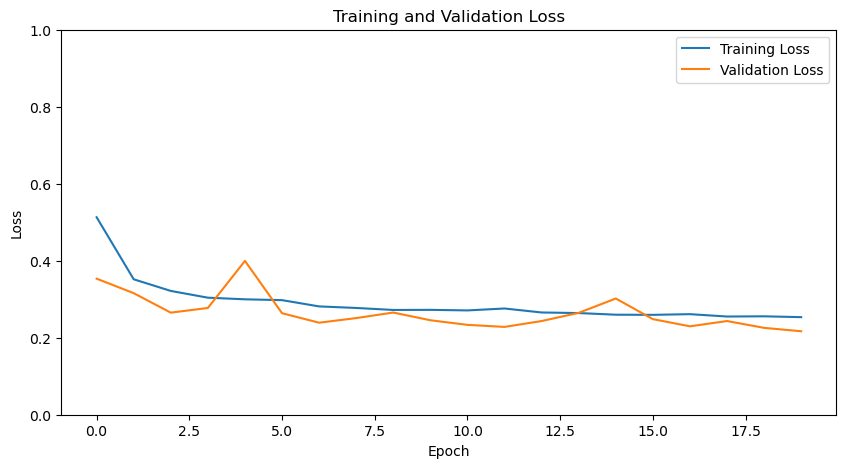

In [104]:
import matplotlib.pyplot as plt


# visualization
plt.figure(figsize=(10,5))
plt.plot(train_hist, label='Training Loss')
plt.plot(val_hist, label='Validation Loss')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

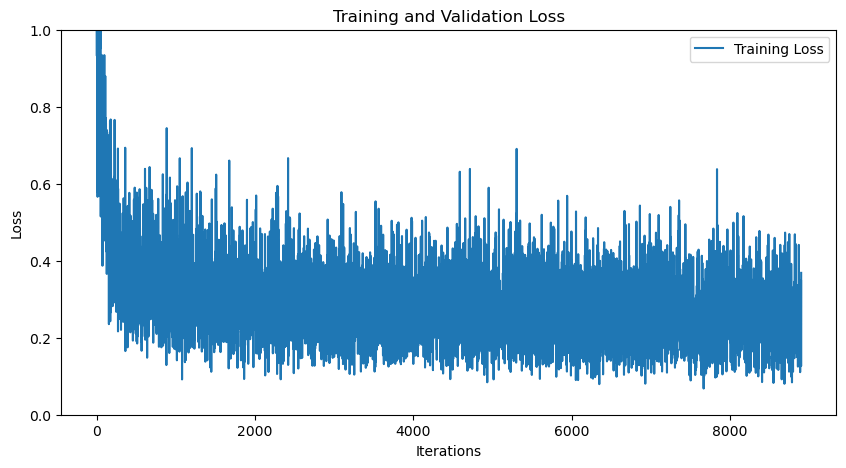

In [105]:
# visualization
plt.figure(figsize=(10,5))
plt.plot(train_hist_iter, label='Training Loss')
plt.ylim([0,1])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

The result has some randomness, so we should use the saved models for the best performance.

### Grid Search (We aren't going to conduct grid search on cloud)

Among these parameter combinations, these are the parameters that achieved relatively good results. They all showed a early sign of overfitting. In terms of overfitting, the third one has the best performance (lowest val loss). Then, the fourth one has the second best performance. The 4th model is special because it is the only model that didn't trigger early stop. If I gave it more epochs, or a slightly higher lr, its performance maybe even better.

1. {'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 5e-05, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1348 | 0.1997
2. {'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 0.0001, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1235 | 0.1974
3. **{'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 0.0005, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1421 | 0.1797**  (based on several experiments, this hyperparameter is best for the adam optimizer)
4. **_{'hidden_size': 256, 'depth': 10, 'dropout_p': 0.1, 'lr': 0.0005, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1416 | 0.1851_**
5. {'hidden_size': 256, 'depth': 10, 'dropout_p': 0.1, 'lr': 0.0001, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1187 | 0.2004

There is also another model that didn't trigger early stopping.

{'hidden_size': 256, 'depth': 15, 'dropout_p': 0.1, 'lr': 0.0005, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1646 | 0.1892

**It seems that 5e-4 is the best learning rate for Adam optimizer trained model, since 3 of the high performance models use `lr` = 5e-4**

On the other hand, the models training loss is still very high, so overfitting may not be the primary problem. These models may still lack the capability to learn enough paterns of the data.


In [106]:
from sklearn.metrics import r2_score
val_loss = 0 
train_loss = 0
r2_train = 0
r2 = 0
with torch.no_grad():
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        train_loss += loss.item() * inputs.size(0)
        r2_train += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)

r2_train /= len(dataset_train)
train_loss /= len(dataset_train)
print(f'train_loss: {train_loss} | train_r2_score: {r2_train}')

with torch.no_grad():
    for inputs, targets in validate_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)
        r2 += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)
r2 /= len(dataset_validate)
val_loss /= len(dataset_validate)

print(f'val_loss: {val_loss} | val_r2_score: {r2}')

train_loss: 0.2081911930614236 | train_r2_score: 0.7913833147874035
val_loss: 0.21678249863776816 | val_r2_score: 0.7939345391214088


这里的表现不够好，只是展示功能

### SGD

let's try the SGD optimizer

In [109]:
import matplotlib.pyplot as plt
def train_visualization_SGD(model,train_dataloader,validate_dataloader,lr=1e-2,num_epochs=500,sche_patience = 20):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum= 0.95)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=sche_patience)
    best_val_loss = np.inf
    patience = 50
    counter = 0
    train_hist = []
    val_hist = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            # calculate the gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataset_train)
        train_hist.append(epoch_loss)
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in validate_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs).squeeze(-1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)


        val_loss /= len(dataset_validate)
        val_hist.append(val_loss)
        scheduler.step(val_loss)

        # early stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
        
        if epoch % 10 == 0:
            print(f'{epoch} train | val loss: {epoch_loss:.4f} | {val_loss:.4f}')
    # visualization
    plt.figure(figsize=(10,5))
    plt.plot(train_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    
    return val_loss


## **Best Model 1**

0 train | val loss: 1.0063 | 1.0502


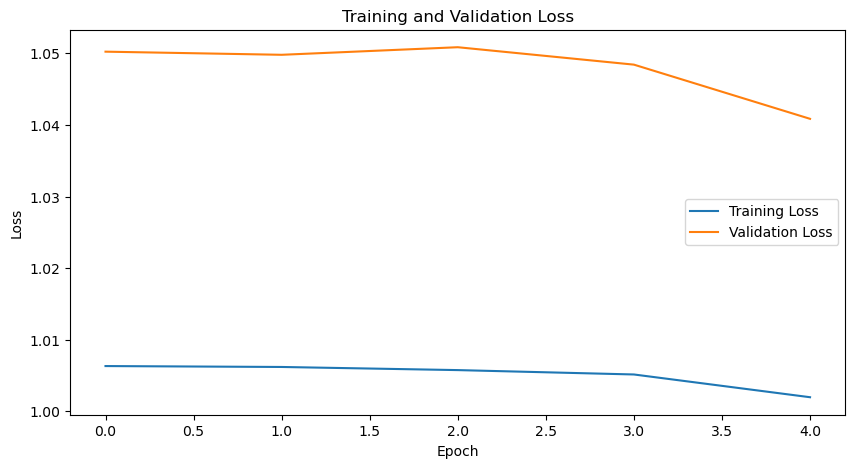

1.040854888728926

In [110]:
# Try the SGD optimizer with a high patience
# model_SGD_1 = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0).to(device)
# train_visualization_SGD(model_SGD_1,train_dataloader,validate_dataloader,lr=1e-3,num_epochs=300,sche_patience=50)
# decrease the patience
model_SGD_1 = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0).to(device)
train_visualization_SGD(model_SGD_1,train_dataloader,validate_dataloader,lr=1e-3,num_epochs=5,sche_patience=10)  # num_epoch = 170 is the best

Calculate the metrics

In [111]:
from sklearn.metrics import r2_score
val_loss = 0 
train_loss = 0
r2_train = 0
r2 = 0
criterion = nn.MSELoss()
with torch.no_grad():
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_SGD_1(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        train_loss += loss.item() * inputs.size(0)
        r2_train += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)

r2_train /= len(dataset_train)
train_loss /= len(dataset_train)
print(f'train_loss: {train_loss} | train_r2_score: {r2_train}')

with torch.no_grad():
    for inputs, targets in validate_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_SGD_1(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)
        r2 += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)
r2 /= len(dataset_validate)
val_loss /= len(dataset_validate)

print(f'val_loss: {val_loss} | val_r2_score: {r2}')

train_loss: 0.9967546574835847 | train_r2_score: 0.005623607383765259
val_loss: 1.0408549115120393 | val_r2_score: 0.0055383790002037905


Based on these experiments, I can preliminarily conclude that, after hyperparameter tuning, **the Adam optimizer achieves a validation loss of approximately 0.18 on this dataset.** In contrast, the SGD optimizer delivers improved performance, reaching a validation loss of around 0.16 when using a subset of the optimal parameters identified through the Adam tuning process, such as network width and depth. **For this model, the validation R² score has reached 0.83, which is an acceptable level.**

## Model 2

Ensembled NN 

This model is overfitted, which could be used for ensemble models' parameters

In [ ]:
# model_adam_overfitted = NN_Model_1(hidden_size=256,num_hidden_layers=15,activation_function='LeakyReLU',dropout_p=0).to(device)
# val_loss_final = train_visualization(model_adam_overfitted,train_dataloader,validate_dataloader,lr=3e-4,num_epochs=400,weight_decay=1e-7)

In [117]:
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 

**Model training**

Model 1 training finished | Training Loss: 0.28660159161583265
Model 2 training finished | Training Loss: 0.28076349353220825
Model 3 training finished | Training Loss: 0.2792271462016915
Model 4 training finished | Training Loss: 0.3749153143194712
Model 5 training finished | Training Loss: 0.2907771455077569
Model 6 training finished | Training Loss: 0.28953870646799496
Model 7 training finished | Training Loss: 0.30088381294957955
Model 8 training finished | Training Loss: 0.3601308251352615
Model 9 training finished | Training Loss: 0.3672380834493379
Model 10 training finished | Training Loss: 0.2705172940978763


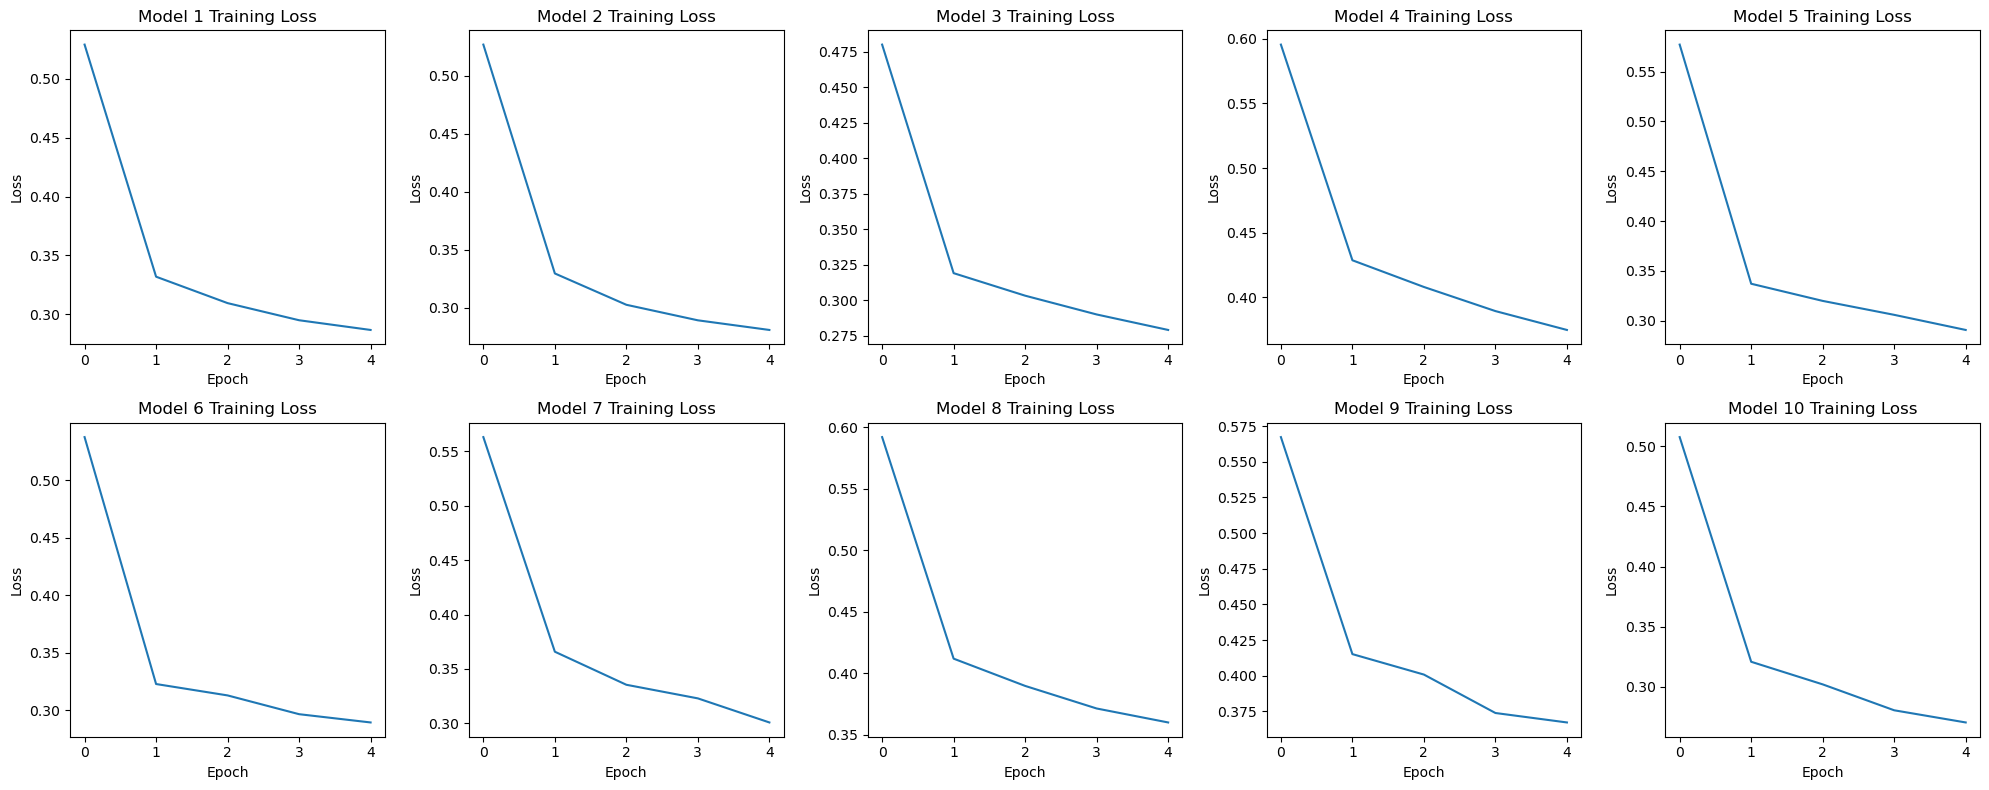

Ensemble Validation Loss: 1.1182307004928589


In [118]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

n_estimators = 10  
num_epochs = 5 # 同样地，减少epochs数展示一下 250 左右比较好
feature_subsample_size = int(X_train.shape[1] * 0.8)  
models = []
histories = []

test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 
criterion = nn.MSELoss()  # Choose the appropriate loss function

for idx in range(n_estimators):
    # Randomly select feature indices
    feature_indices = np.random.choice(X_train.shape[1], feature_subsample_size, replace=False)
    # Randomly select sample indices (optional)
    sample_indices = np.random.choice(len(X_train), size=int(len(X_train)*0.8), replace=True)
    
    X_subset = X_train[sample_indices][:, feature_indices]
    y_subset = y_train[sample_indices]
    
    dataset_partial = MyDataset(X_subset, y_subset)
    train_partial_dataloader = DataLoader(dataset_partial, batch_size=256, shuffle=True)
    
    # Define the model
    num_features_subset = X_subset.shape[1]  # Input size corresponds to the number of selected features
    model = NN_Model_1(input_size=num_features_subset, hidden_size=256, num_hidden_layers=15,
                       activation_function='LeakyReLU', dropout_p=0).to(device)
    criterion = nn.MSELoss()  # Choose appropriate loss function according to task
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-7)
    
    # Train the model
    train_hist = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_partial_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            # Zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataset_partial)
        train_hist.append(epoch_loss)

    print(f'Model {idx+1} training finished | Training Loss: {epoch_loss}')
    
    # Save the model, corresponding feature indices, and training history
    models.append((model, feature_indices))
    histories.append(train_hist)

# Plot training loss curves
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, history in enumerate(histories):
    axes[i].plot(history)
    axes[i].set_title(f'Model {i+1} Training Loss')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Ensemble prediction on validation data
ensemble_predictions = []
with torch.no_grad():
    for model, feature_indices in models:
        model.eval()
        val_predictions = []
        for inputs, targets in validate_dataloader:
            # Select the same features used in training
            inputs = inputs[:, feature_indices].to(device)
            outputs = model(inputs).squeeze(-1)
            val_predictions.append(outputs.cpu().numpy())
        val_predictions = np.concatenate(val_predictions)
        ensemble_predictions.append(val_predictions)

# Average the predictions from all models
ensemble_predictions = np.mean(ensemble_predictions, axis=0)

# Get the true targets from validation data
val_targets = []
for _, targets in validate_dataloader:
    val_targets.append(targets.numpy())
val_targets = np.concatenate(val_targets)

# Compute validation loss
val_loss = np.mean((ensemble_predictions - val_targets) ** 2)
print(f'Ensemble Validation Loss: {val_loss}')


The ensemble NN's performance is great.

**Saving Model 2** 

**Read the Ensemble NN model Back**

我感觉你不一定要读取模型，只要大概运行一下训练就行了

In [ ]:
# Load models and feature indices
loaded_models = []
n_estimators = 10  
feature_subsample_size = int(X_train.shape[1] * 0.8)  
for idx in range(n_estimators):
    # Load the model's state_dict
    model_path = f'saved_models/model_{idx+1}_state_dict.pth'
    state_dict = torch.load(model_path,weights_only=True)
    
    # Create a new model instance
    model = NN_Model_1(input_size=64, hidden_size=256, num_hidden_layers=15,
                       activation_function='LeakyReLU', dropout_p=0).to(device)
    model.load_state_dict(state_dict)
    model.eval()
    
    # Load the feature indices
    feature_indices_path = f'saved_models/model_{idx+1}_feature_indices.npy'
    feature_indices = np.load(feature_indices_path)
    
    # Append to the list
    loaded_models.append((model, feature_indices))
    
    print(f'Model {idx+1} and feature indices loaded.')


In [119]:
from sklearn.metrics import mean_squared_error, r2_score

def ensemble_predict(models, dataloader, device='cpu'):
    """
    Make predictions using an ensemble of neural network models.

    Parameters:
    - models: list of tuples (model, feature_indices)
    - dataloader: PyTorch DataLoader providing input data
    - device: 'cpu' or 'cuda'

    Returns:
    - ensemble_predictions: numpy array of ensemble predictions
    - targets: numpy array of true target values
    """
    import numpy as np
    ensemble_predictions = []
    targets = []
    
    # Initialize a list to hold predictions from each model
    model_predictions_list = [[] for _ in models]
    
    with torch.no_grad():
        for batch_idx, (inputs, batch_targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            batch_predictions = []
            
            for model_idx, (model, feature_indices) in enumerate(models):
                model.eval()
                inputs_subset = inputs[:, feature_indices]
                outputs = model(inputs_subset).squeeze(-1)
                model_predictions_list[model_idx].append(outputs.cpu().numpy())
            
            # Collect targets once
            if batch_idx == 0:
                targets = batch_targets.numpy()
            else:
                targets = np.concatenate((targets, batch_targets.numpy()))
    
    # Concatenate predictions from each model and average
    for model_idx in range(len(models)):
        model_preds = np.concatenate(model_predictions_list[model_idx])
        ensemble_predictions.append(model_preds)
    
    # Compute the mean prediction across all models
    ensemble_predictions = np.mean(ensemble_predictions, axis=0)
    
    return ensemble_predictions, targets


    

# 使用函数进行预测
ensemble_preds, true_targets = ensemble_predict(models, test_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Ensemble MSE: {mse:.4f}')
print(f'Ensemble R² Score: {r2:.4f}')


Ensemble MSE: 0.2502
Ensemble R² Score: 0.7559


In [ ]:
ensemble_preds, true_targets = ensemble_predict(loaded_models, train_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Training Ensemble MSE: {mse:.4f}')
print(f'Training Ensemble R² Score: {r2:.4f}')

ensemble_preds, true_targets = ensemble_predict(loaded_models, validate_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Validation Ensemble MSE: {mse:.4f}')
print(f'Validation Ensemble R² Score: {r2:.4f}')

ensemble_preds, true_targets = ensemble_predict(loaded_models, test_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Test Ensemble MSE: {mse:.4f}')
print(f'Test Ensemble R² Score: {r2:.4f}')

In [120]:
ensemble_preds, true_targets = ensemble_predict(models, train_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Training Ensemble MSE: {mse:.4f}')
print(f'Training Ensemble R² Score: {r2:.4f}')

ensemble_preds, true_targets = ensemble_predict(models, validate_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Validation Ensemble MSE: {mse:.4f}')
print(f'Validation Ensemble R² Score: {r2:.4f}')

ensemble_preds, true_targets = ensemble_predict(models, test_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Test Ensemble MSE: {mse:.4f}')
print(f'Test Ensemble R² Score: {r2:.4f}')

Training Ensemble MSE: 0.2391
Training Ensemble R² Score: 0.7624
Validation Ensemble MSE: 0.2455
Validation Ensemble R² Score: 0.7662
Test Ensemble MSE: 0.2502
Test Ensemble R² Score: 0.7559


# TASK III SPARK

## Import Spark and Read The Data Back here

In [109]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

spark = SparkSession.builder \
    .master("yarn") \
    .appName("SparkML-yarn") \
    .getOrCreate()

In [8]:
from pyspark.sql.functions import col, when, isnull, count, lit, avg, sum, isnan, desc, row_number, expr, regexp_extract, concat
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

In [6]:
# 假设您的 GCS 路径为：
bucket_name = 'dataproc-staging-us-central1-117936207860-5guroa6a'
path = f'gs://{bucket_name}/notebooks/jupyter/data/df_cleaned_parquet'


# 从 GCS 读取 Parquet 格式的数据
df_cleaned_loaded = spark.read.parquet(path)
df_cleaned_loaded.show()


24/11/12 20:45:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+-----------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+-------------------+--------------------+------------+-------------+------------------+-----------+-------------------------+--------------+----------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+--

In [9]:
df_read = df_cleaned_loaded
df_read=df_read.filter(col('gender')==1)
df_read.show(1, vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | RW, ST, CF           
 overall                     | 93                   
 potential                   | 93                   
 value_eur                   | 650000               
 wage_eur                    | 320000               
 age                         | 34                   
 dob                         | 1987-06-24           
 height_cm                   | 170                  
 weight_kg                   | 72                   
 club_team_id                | 73                   
 club_name                   | Paris Saint-Germain  
 league_name                 | French Ligue 1       
 league_level                | 1                    
 club_position               | RW                   
 club_jersey_number          | 30             

### Run these codes:    (1)->(7)

**(1) Contract year calculation**

In [10]:
from pyspark.sql import functions as F
df_read = df_read.withColumn("contract_years_remaining", F.col("club_contract_valid_until") - F.year(F.col("club_joined")))
df_read.show(20, vertical = True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | RW, ST, CF           
 overall                     | 93                   
 potential                   | 93                   
 value_eur                   | 650000               
 wage_eur                    | 320000               
 age                         | 34                   
 dob                         | 1987-06-24           
 height_cm                   | 170                  
 weight_kg                   | 72                   
 club_team_id                | 73                   
 club_name                   | Paris Saint-Germain  
 league_name                 | French Ligue 1       
 league_level                | 1                    
 club_position               | RW                   
 club_jersey_number          | 30             

**(2) furtherly drop unnecessary features**

In [11]:
delete_features = ['gender','nationality_id', 'nationality_name', 'work_rate', 'body_type', 'real_face', 'short_name', 'long_name','sofifa_id','unique_id','year','player_positions', 'dob', 'club_joined','club_name']
df_read = df_read.drop(*delete_features)
df_read.show(2,vertical = True)

-RECORD 0-------------------------------------------
 overall                     | 93                   
 potential                   | 93                   
 value_eur                   | 650000               
 wage_eur                    | 320000               
 age                         | 34                   
 height_cm                   | 170                  
 weight_kg                   | 72                   
 club_team_id                | 73                   
 league_name                 | French Ligue 1       
 league_level                | 1                    
 club_position               | RW                   
 club_jersey_number          | 30                   
 club_contract_valid_until   | 2023                 
 preferred_foot              | Left                 
 weak_foot                   | 4                    
 skill_moves                 | 4                    
 international_reputation    | 5                    
 release_clause_eur          | 144300000      

**(3) Define Columns Type**

In [12]:
continuous_cols = ['overall','potential','wage_eur','age','height_cm', 'weight_kg', 'league_level','weak_foot', 'skill_moves','international_reputation',
                  'release_clause_eur','pace', "shooting", "passing", "dribbling", "defending", "physic", "attacking_crossing", "attacking_finishing", 
                   "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve",
                   "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed",
                   "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina",
                   "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning",
                   "mentality_vision", "mentality_penalties", "mentality_composure", "defending_marking_awareness", "defending_standing_tackle",
                   "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", 
                   "goalkeeping_reflexes", "ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "cm", "rcm", "rm", 
                   "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk",'contract_years_remaining',
                    'overall','club_team_id', 'club_jersey_number', 'club_contract_valid_until']
nominal_cols = []
binary_cols = ['preferred_foot']


**(4) Transfer binary_cols**

In [13]:
from pyspark.sql.functions import when, col

df_read = df_read.withColumn(
    "preferred_foot", 
    when(col("preferred_foot") == "Left", 0.0)
    .when(col("preferred_foot") == "Right", 1.0)
    .otherwise(None)  
)
df_read.show(1,vertical=True)

-RECORD 0-------------------------------------
 overall                     | 93             
 potential                   | 93             
 value_eur                   | 650000         
 wage_eur                    | 320000         
 age                         | 34             
 height_cm                   | 170            
 weight_kg                   | 72             
 club_team_id                | 73             
 league_name                 | French Ligue 1 
 league_level                | 1              
 club_position               | RW             
 club_jersey_number          | 30             
 club_contract_valid_until   | 2023           
 preferred_foot              | 0.0            
 weak_foot                   | 4              
 skill_moves                 | 4              
 international_reputation    | 5              
 release_clause_eur          | 144300000      
 pace                        | 85             
 shooting                    | 92             
 passing     

**(5) The transformer pipeline**

In [14]:

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):                             
        output_df = dataset.withColumn('outcome', col('value_eur')).drop("value_eur")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()
    
    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols ) # actually there's no nominal cols to transfer

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ['overall','club_team_id', 'club_jersey_number', 'club_contract_valid_until']

    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    
    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    


    # Creating the outcome and conduct standardization
    stage_outcome = OutcomeCreater()
    assembler_outcome = VectorAssembler(inputCols=['outcome'], outputCol='assembled_outcome')
    scaler_outcome = StandardScaler(inputCol='assembled_outcome', outputCol='scaled_outcome', withMean=True, withStd=True)
    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler, stage_outcome,assembler_outcome, scaler_outcome,stage_column_dropper])
    return pipeline 

## train and test

In [15]:
train_df, test_df = df_read.randomSplit([0.8, 0.2], seed=42)
train_df.count()

113692

**(6) Fit & Transform**

In [16]:

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(train_df)
from pyspark.ml.functions import vector_to_array
df_train = preprocess_pipeline_model.transform(train_df)
df_test = preprocess_pipeline_model.transform(test_df)
df_train = df_train.drop('outcome')
df_test = df_test.drop('outcome')

#vector_to_array is necessary since the standardization process transfers the outcome to a vector
df_train = df_train.withColumn('outcome',vector_to_array(col('scaled_outcome'))[0])
df_train = df_train.drop('scaled_outcome','assembled_outcome','league_name','club_position')

df_test = df_test.withColumn('outcome',vector_to_array(col('scaled_outcome'))[0])
df_test = df_test.drop('scaled_outcome','assembled_outcome','league_name','club_position')


### B.Create Spark's Dataset

## spark gbt

In [17]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol='features', labelCol='outcome',maxDepth=15)
gbt_model = gbt.fit(df_train)
df_train_pred = gbt_model.transform(df_train)
df_train_pred.select("features", "outcome", "prediction").show(1)


24/11/12 20:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1355.6 KiB
24/11/12 20:47:49 WARN DAGScheduler: Broadcasting large task binary with size 1973.0 KiB
24/11/12 20:47:51 WARN DAGScheduler: Broadcasting large task binary with size 1725.2 KiB
24/11/12 20:47:51 WARN DAGScheduler: Broadcasting large task binary with size 1725.7 KiB
24/11/12 20:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1726.3 KiB
24/11/12 20:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1727.4 KiB
24/11/12 20:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1729.1 KiB
24/11/12 20:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1732.1 KiB
24/11/12 20:47:53 WARN DAGScheduler: Broadcasting large task binary with size 1737.1 KiB
24/11/12 20:47:53 WARN DAGScheduler: Broadcasting large task binary with size 1745.3 KiB
24/11/12 20:47:53 WARN DAGScheduler: Broadcasting large task binary with size 1758.1 KiB
24/11/12 20:47:53 WAR

24/11/12 20:48:21 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 20:48:21 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 20:48:22 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 20:48:22 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 20:48:22 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 20:48:23 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:48:23 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:48:24 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/11/12 20:48:24 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/11/12 20:48:25 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 20:48:25 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/11/12 20:48:26 WARN DAGScheduler: Broadcasting larg

24/11/12 20:49:10 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
24/11/12 20:49:11 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
24/11/12 20:49:11 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/11/12 20:49:12 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
24/11/12 20:49:13 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
24/11/12 20:49:14 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
24/11/12 20:49:16 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
24/11/12 20:49:16 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
24/11/12 20:49:17 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
24/11/12 20:49:17 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
24/11/12 20:49:18 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
24/11/12 20:49:18 WARN DAGScheduler: Broadcasting larg

+--------------------+-------------------+-------------------+
|            features|            outcome|         prediction|
+--------------------+-------------------+-------------------+
|[7.48465001834289...|-0.7254869983959134|-0.7283285477608213|
+--------------------+-------------------+-------------------+
only showing top 1 row



In [18]:
df_test_pred = gbt_model.transform(df_test)

In [19]:
df_test_pred.show(1)

+--------------------+-------------------+-------------------+
|            features|            outcome|         prediction|
+--------------------+-------------------+-------------------+
|[8.12164150926569...|-0.7106818323644059|-0.7134286840206343|
+--------------------+-------------------+-------------------+
only showing top 1 row



In [20]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

# Evaluate RMSE on the training dataset
train_rmse = evaluator.evaluate(df_train_pred)
print(f"Train RMSE: {train_rmse}")

# Evaluate RMSE on the test dataset
test_rmse = evaluator.evaluate(df_test_pred)
print(f"Test RMSE: {test_rmse}")


Train RMSE: 0.05211369905168418


Test RMSE: 0.4315913805991195


In [21]:
gbt = GBTRegressor(featuresCol='features', labelCol='outcome')

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 50]) \
    .addGrid(gbt.maxDepth, [10]) \
    .addGrid(gbt.stepSize, [0.05, 0.2]) \
    .build()

evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(df_train)

best_model = cv_model.bestModel

24/11/12 20:51:08 WARN DAGScheduler: Broadcasting large task binary with size 1027.7 KiB
24/11/12 20:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1025.4 KiB
24/11/12 20:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
24/11/12 20:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1026.5 KiB
24/11/12 20:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1027.6 KiB
24/11/12 20:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1029.9 KiB
24/11/12 20:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1034.4 KiB
24/11/12 20:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1043.2 KiB
24/11/12 20:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1060.0 KiB
24/11/12 20:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1091.1 KiB
24/11/12 20:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1143.5 KiB
24/11/12 20:51:11 WAR

24/11/12 20:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1452.4 KiB
24/11/12 20:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1449.6 KiB
24/11/12 20:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1450.0 KiB
24/11/12 20:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1450.6 KiB
24/11/12 20:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1451.7 KiB
24/11/12 20:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1454.0 KiB
24/11/12 20:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1458.2 KiB
24/11/12 20:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1466.7 KiB
24/11/12 20:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1482.9 KiB
24/11/12 20:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1510.3 KiB
24/11/12 20:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1553.5 KiB
24/11/12 20:51:58 WAR

24/11/12 20:52:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 20:52:20 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/11/12 20:52:20 WARN DAGScheduler: Broadcasting larg

24/11/12 20:52:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:50 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:50 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:50 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:51 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:52:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/11/12 20:52:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/11/12 20:52:52 WARN DAGScheduler: Broadcasting larg

24/11/12 20:53:16 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/11/12 20:53:17 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/11/12 20:53:17 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/11/12 20:53:17 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 20:53:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 20:53:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 20:53:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 20:53:19 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 20:53:19 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 20:53:19 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 20:53:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 20:53:20 WARN DAGScheduler: Broadcasting larg

24/11/12 20:53:57 WARN DAGScheduler: Broadcasting large task binary with size 1324.2 KiB
24/11/12 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1320.9 KiB
24/11/12 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1321.4 KiB
24/11/12 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1322.0 KiB
24/11/12 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1323.1 KiB
24/11/12 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1325.4 KiB
24/11/12 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
24/11/12 20:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1339.0 KiB
24/11/12 20:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1357.2 KiB
24/11/12 20:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1389.4 KiB
24/11/12 20:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1441.9 KiB
24/11/12 20:53:59 WAR

24/11/12 20:54:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:54:17 WARN DAGScheduler: Broadcasting larg

24/11/12 20:54:37 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:39 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:39 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:39 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:39 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:40 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:54:40 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 20:54:40 WARN DAGScheduler: Broadcasting larg

24/11/12 20:55:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/11/12 20:55:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/11/12 20:55:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/11/12 20:55:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 20:55:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 20:55:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 20:55:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 20:55:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 20:55:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 20:55:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 20:55:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 20:55:08 WARN DAGScheduler: Broadcasting larg

24/11/12 20:55:36 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:55:36 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:55:36 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:55:37 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:55:37 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:55:37 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:55:38 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:55:38 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:55:39 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/11/12 20:55:58 WARN DAGScheduler: Broadcasting large task binary with size 1014.6 KiB
24/11/12 20:55:58 WARN DAGScheduler: Broadcasting large task binary with size 1014.3 KiB
24/11/12 20:55:58 WARN DAGScheduler: Broadcastin

24/11/12 20:56:42 WARN DAGScheduler: Broadcasting large task binary with size 1324.3 KiB
24/11/12 20:56:42 WARN DAGScheduler: Broadcasting large task binary with size 1327.4 KiB
24/11/12 20:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1327.8 KiB
24/11/12 20:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1328.4 KiB
24/11/12 20:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
24/11/12 20:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
24/11/12 20:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1336.3 KiB
24/11/12 20:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1345.1 KiB
24/11/12 20:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1361.6 KiB
24/11/12 20:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1391.0 KiB
24/11/12 20:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1439.6 KiB
24/11/12 20:56:44 WAR

24/11/12 20:57:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:57:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:57:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:57:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:57:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:57:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:57:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/12 20:57:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:57:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 20:57:02 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/12 20:57:02 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/12 20:57:02 WARN DAGScheduler: Broadcasting larg

24/11/12 20:57:22 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:57:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/11/12 20:57:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/11/12 20:57:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/11/12 20:57:23 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:57:23 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:57:23 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:57:23 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:57:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:57:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:57:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/12 20:57:25 WARN DAGScheduler: Broadcasting larg

24/11/12 20:57:47 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/11/12 20:57:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/11/12 20:57:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/11/12 20:57:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/11/12 20:57:49 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/11/12 20:57:49 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/11/12 20:57:49 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
24/11/12 20:57:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/11/12 20:57:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/11/12 20:57:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/11/12 20:57:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/11/12 20:57:51 WARN DAGScheduler: Broadcasting larg

24/11/12 20:58:18 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/11/12 20:58:18 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/11/12 20:58:18 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/11/12 20:58:19 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/11/12 20:58:19 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/11/12 20:58:19 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/11/12 20:58:20 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/11/12 20:58:20 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
24/11/12 20:58:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:58:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:58:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/11/12 20:58:22 WARN DAGScheduler: Broadcasting larg

24/11/12 20:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1738.3 KiB
24/11/12 20:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1739.5 KiB
24/11/12 20:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1741.8 KiB
24/11/12 20:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1746.2 KiB
24/11/12 20:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1754.4 KiB
24/11/12 20:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1770.8 KiB
24/11/12 20:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1798.3 KiB
24/11/12 20:58:53 WARN DAGScheduler: Broadcasting large task binary with size 1843.1 KiB
24/11/12 20:58:53 WARN DAGScheduler: Broadcasting large task binary with size 1840.5 KiB
24/11/12 20:58:53 WARN DAGScheduler: Broadcasting large task binary with size 1841.0 KiB
24/11/12 20:58:53 WARN DAGScheduler: Broadcasting large task binary with size 1841.5 KiB
24/11/12 20:58:53 WAR

24/11/12 20:59:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 20:59:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 20:59:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/12 20:59:14 WARN DAGScheduler: Broadcasting larg

24/11/12 20:59:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 20:59:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 20:59:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 20:59:35 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:59:36 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:59:36 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:59:36 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:59:37 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 20:59:38 WARN DAGScheduler: Broadcasting larg

24/11/12 21:00:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:00:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:00:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:00:04 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:00:04 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:00:04 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:00:04 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:00:05 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:00:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/11/12 21:00:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/11/12 21:00:06 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/11/12 21:00:06 WARN DAGScheduler: Broadcasting larg

24/11/12 21:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1092.6 KiB
24/11/12 21:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1093.1 KiB
24/11/12 21:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1093.7 KiB
24/11/12 21:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1094.8 KiB
24/11/12 21:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1097.1 KiB
24/11/12 21:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
24/11/12 21:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1109.4 KiB
24/11/12 21:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB
24/11/12 21:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1147.8 KiB
24/11/12 21:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1184.2 KiB
24/11/12 21:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1003.1 KiB
24/11/12 21:01:21 WAR

24/11/12 21:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1733.2 KiB
24/11/12 21:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1733.7 KiB
24/11/12 21:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1734.2 KiB
24/11/12 21:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1735.4 KiB
24/11/12 21:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1737.7 KiB
24/11/12 21:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1742.2 KiB
24/11/12 21:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1750.6 KiB
24/11/12 21:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1766.4 KiB
24/11/12 21:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1793.0 KiB
24/11/12 21:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1838.2 KiB
24/11/12 21:01:38 WARN DAGScheduler: Broadcasting large task binary with size 1836.3 KiB
24/11/12 21:01:38 WAR

24/11/12 21:01:55 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/11/12 21:01:55 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/11/12 21:01:55 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/11/12 21:01:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 21:01:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 21:01:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 21:01:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 21:01:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 21:01:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 21:01:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 21:01:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/11/12 21:01:58 WARN DAGScheduler: Broadcasting larg

24/11/12 21:02:19 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 21:02:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 21:02:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 21:02:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 21:02:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 21:02:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 21:02:21 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/11/12 21:02:21 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 21:02:21 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 21:02:22 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 21:02:22 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/11/12 21:02:22 WARN DAGScheduler: Broadcasting larg

24/11/12 21:02:47 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/11/12 21:02:47 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:48 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:48 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:48 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:50 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:50 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/11/12 21:02:50 WARN DAGScheduler: Broadcasting larg

24/11/12 21:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1359.7 KiB
24/11/12 21:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1360.2 KiB
24/11/12 21:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1360.7 KiB
24/11/12 21:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1361.9 KiB
24/11/12 21:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1364.1 KiB
24/11/12 21:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1368.3 KiB
24/11/12 21:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1375.3 KiB
24/11/12 21:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1389.1 KiB
24/11/12 21:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1412.7 KiB
24/11/12 21:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1449.1 KiB
24/11/12 21:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1445.8 KiB
24/11/12 21:03:27 WAR

24/11/12 21:03:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 21:03:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 21:03:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 21:03:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 21:03:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 21:03:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/12 21:03:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/12 21:03:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/12 21:03:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/12 21:03:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/12 21:03:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/11/12 21:03:45 WARN DAGScheduler: Broadcasting larg

24/11/12 21:04:05 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:07 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:07 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:07 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:07 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/11/12 21:04:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/11/12 21:04:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/11/12 21:04:08 WARN DAGScheduler: Broadcasting larg

24/11/12 21:04:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 21:04:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 21:04:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 21:04:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/12 21:04:33 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/12 21:04:34 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/12 21:04:34 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/12 21:04:34 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/12 21:04:34 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/12 21:04:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/12 21:04:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/11/12 21:04:35 WARN DAGScheduler: Broadcasting larg

24/11/12 21:05:53 WARN DAGScheduler: Broadcasting large task binary with size 1975.7 KiB
24/11/12 21:05:53 WARN DAGScheduler: Broadcasting large task binary with size 1978.0 KiB
24/11/12 21:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1982.1 KiB
24/11/12 21:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1989.4 KiB
24/11/12 21:05:54 WARN DAGScheduler: Broadcasting large task binary with size 2001.9 KiB
24/11/12 21:05:54 WARN DAGScheduler: Broadcasting large task binary with size 2022.9 KiB
24/11/12 21:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/11/12 21:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/11/12 21:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/11/12 21:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/11/12 21:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/11/12 21:05:56 WARN DAGScheduler:

24/11/12 21:06:17 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:17 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:17 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:17 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:18 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:18 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:18 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:18 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:19 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:19 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/11/12 21:06:19 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/11/12 21:06:20 WARN DAGScheduler: Broadcasting larg

24/11/12 21:06:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/11/12 21:06:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/11/12 21:06:45 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:45 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:48 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/11/12 21:06:48 WARN DAGScheduler: Broadcasting larg

24/11/12 21:07:16 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/12 21:07:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/12 21:07:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/12 21:07:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/12 21:07:18 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/12 21:07:18 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/12 21:07:18 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/12 21:07:19 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/11/12 21:07:19 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/11/12 21:07:20 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/11/12 21:07:20 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/11/12 21:07:20 WARN DAGScheduler: Broadcasting larg

In [22]:
avg_losses = cv_model.avgMetrics


print("Cross-validation average loss:", avg_losses)

Cross-validation average loss: [0.39977700566781665, 0.4075295681423423, 0.38984522035274255, 0.413719615596515]


In [23]:
df_train_pred = best_model.transform(df_train)
df_test_pred = best_model.transform(df_test)

df_test_pred.show(1)
# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

# Evaluate RMSE on the training dataset
train_rmse = evaluator.evaluate(df_train_pred)
print(f"Train RMSE: {train_rmse}")

# Evaluate RMSE on the test dataset
test_rmse = evaluator.evaluate(df_test_pred)
print(f"Test RMSE: {test_rmse}")

+--------------------+-------------------+-------------------+
|            features|            outcome|         prediction|
+--------------------+-------------------+-------------------+
|[8.12164150926569...|-0.7106818323644059|-0.7142902467912511|
+--------------------+-------------------+-------------------+
only showing top 1 row



Train RMSE: 0.16242759121465408


Test RMSE: 0.37624436187753657


## hypertuning rf

In [24]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
rf = RandomForestRegressor(featuresCol='features', labelCol='outcome')

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 75]) \
    .addGrid(rf.maxDepth, [12]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(df_train)

best_model = cv_model.bestModel

24/11/12 21:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1424.5 KiB
24/11/12 21:08:05 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/11/12 21:08:08 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/11/12 21:08:12 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/11/12 21:08:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
24/11/12 21:08:18 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/11/12 21:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
24/11/12 21:08:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/11/12 21:08:24 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
24/11/12 21:08:26 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
24/11/12 21:08:28 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
24/11/12 21:08:31 WARN DAGScheduler: Br

24/11/12 21:19:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/11/12 21:19:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/11/12 21:19:26 WARN DAGScheduler: Broadcasting large task binary with size 1191.1 KiB
24/11/12 21:19:28 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/11/12 21:19:32 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/11/12 21:19:37 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/11/12 21:19:41 WARN DAGScheduler: Broadcasting large task binary with size 1334.2 KiB
24/11/12 21:19:44 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/11/12 21:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1333.5 KiB
24/11/12 21:19:49 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
24/11/12 21:19:51 WARN DAGScheduler: Broadcasting large task binary with size 1333.4 KiB
24/11/12 21:19:53 WARN DAGScheduler: Broad

In [25]:
df_train_pred = best_model.transform(df_train)
df_test_pred = best_model.transform(df_test)

df_test_pred.show(1)
# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

# Evaluate RMSE on the training dataset
train_rmse = evaluator.evaluate(df_train_pred)
print(f"Train RMSE: {train_rmse}")

# Evaluate RMSE on the test dataset
test_rmse = evaluator.evaluate(df_test_pred)
print(f"Test RMSE: {test_rmse}")

+--------------------+-------------------+-------------------+
|            features|            outcome|         prediction|
+--------------------+-------------------+-------------------+
|[8.12164150926569...|-0.7106818323644059|-0.7080549070264339|
+--------------------+-------------------+-------------------+
only showing top 1 row



Train RMSE: 0.31586275965036853


Test RMSE: 0.37448739860049984
